In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
%matplotlib inline

#Import and Clean Data

In [2]:
def difficulty(df):
    '''
    add question difficulty
    '''
    

def clean_data(df):
    '''
    changes column names, creates a column for correct answers
    args: raw dataframe
    returns: cleaned dataframe
    '''
    d = df.copy()
    d.rename(columns={'name.1':'topic'},inplace=True)
    d.rename(columns={'name':'testID'},inplace=True)
    
    #create column for correct answers
    d['correct'] = 0
    d.loc[d['Studentsanswer']==d['CorrectAnswer'],'correct']=1
    
    return d

def addNumTopics(rawDF):
    '''
    get the number of topics associated with each question
    args:df
    returns: df with numTopics attached
    '''
    df = rawDF.copy()
    qg = groupData(df,['firstName','testID','testQuestionNumber','testSectionNumber'],'correct')
    qg2 = qg.groupby(['testID','testQuestionNumber','testSectionNumber']).max().reset_index()
    qg2.sort(['testID','testSectionNumber','testQuestionNumber','firstName'])
    qg2.rename(columns={'size':'numTopics'}, inplace=True)
    df = pd.merge(df, qg2[['testID','testQuestionNumber','testSectionNumber','numTopics']], how='left', on=['testID','testQuestionNumber','testSectionNumber'])
    return df

In [3]:
def groupByStudentTypeTopic(df):
    studentsDF = df[['firstName','lastName','type','topic','correct']]
    grouped = studentsDF.groupby(['firstName','lastName','type','topic'],sort=True)
    return grouped.agg([np.size,np.sum, np.mean,np.std])

def groupData(df,columns,statVar):
    '''
    group the data by the columns, aggregating the statVar with sum, mean, std
    args:
        df: dataframe
        columns:columns to group by
        statVar: column to aggregate.  
    '''
    subDF = df[columns+[statVar]]
    grouped = subDF.groupby(columns,sort=True)
    groupedDF = grouped.agg([np.size,np.sum, np.mean,np.std])[statVar]
    groupedDF = groupedDF.reset_index()
    return groupedDF

def drawHeatmap(df,columns,agg,sortingColumn):
    groupedDF = groupData(df,columns,'correct')
    r = groupedDF.pivot('firstName','type',agg)
    r = r.sort(sortingColumn)

    #sns.set_context(context)
    f=sns.heatmap(r, annot=True)
    f.set_title("Performance by Subject")
    f.set_xlabel("Student")
    f.set_ylabel("Subject")
    return r

In [6]:
fpath = "data/RawStudentData.csv"
rawDF = pd.read_csv(fpath)
df = clean_data(rawDF)
df = addNumTopics(df)
df.loc['testQuestionNumber'>10]

KeyError: True

#Get Distribution of Topics

In [ ]:
def drop_test(df,desc):
    df2 = df.drop(list(np.where(df.testID.str.contains(desc))[0]))
    return df2.reset_index()

def getTopicWeight(df):
    '''
    Calculate the relative weight of each topic within its subject area
    args:
        df: original cleaned data frame
    returns:
        topicsDF: a dataframe with type, topic, and weight of that topic
    '''
    #only considering full tests, so no 'BB's
    d0 = drop_test(df,'BB')
    #YL_6_PP_SAT_S0111 doesn't have topics
    d0=drop_test(d0,'YL_6_PP_SAT_S0111')

    #first get num of questions per topic for each test for each student
    d1 = groupData(d0,['firstName','testID','type','topic'],'correct')
    d1.rename(columns={'size':'questionsPerTopic'}, inplace=True)

    #then get the average number of questions per topic for each test
    d2 = groupData(d1,['type','topic'],'questionsPerTopic')
    d2.rename(columns={'mean':'meanQsPerTopic'}, inplace=True)

    #Get number of questions per test
    tt1 = d0.groupby(['testID','type','testQuestionNumber','testSectionNumber']).agg(np.size)
    tt1=tt1.reset_index()
    tt1 = tt1[['testID','type','testQuestionNumber','testSectionNumber']]
    tt2 = tt1.groupby(['testID','type']).agg([np.size])['testQuestionNumber']
    tt2.rename(columns={'size':'questionsPerTestType'}, inplace=True)
    testQs=tt2.reset_index()

    #Get number of topic appearances per type to establish topic weight (questions)
    d3 = groupData(d2,['type'],'meanQsPerTopic')
    d3 = d3.rename(columns={'sum':'topics_x_Qs'})
    d3 = d3[['type','topics_x_Qs']]

    d2 = pd.merge(d2,d3,how='left',on=['type'])
    d2['topicWeight'] = d2['meanQsPerTopic']/d2['topics_x_Qs']
    d2.sort(['type','topicWeight'],ascending=False)
    topicsDF = d2[['type','topic','topicWeight']]
    return topicsDF
    
getTopicWeight(df)

In [ ]:
def drawTopicsBarChart(cleanDF,subject,title,n_topics=10):
    '''
    Draw a bar chart of topic weights, to get a sense of the broadest topics
    '''
    topicsDF = getTopicWeight(cleanDF)
    df = topicsDF[topicsDF['type']==subject].sort('topicWeight',ascending=False).head(n_topics)
    df = df.sort('topicWeight')
    
    #size and position of bars
    bar_pos = np.arange(df.shape[0])
    bar_size = df['topicWeight']
    bar_labels = df['topic'].tolist()

    #plot
    fig = plt.figure(figsize=[5,5])
    plt.barh(bar_pos,bar_size, align='center', alpha=0.4)
    plt.yticks(bar_pos, bar_labels)
    plt.xticks([],[])
    for x,y in zip(bar_size,bar_pos):
        plt.text(x+0.02*max(bar_size), y, '%.3f' % x, ha='left', va='center')
    plt.title(title)
    
drawTopicsBarChart(df,'reading','Top 10 Reading Topics, by Weight')

In [ ]:
drawTopicsBarChart(df,'math','Top 10 Math Topics, by Weight')

In [ ]:
drawTopicsBarChart(df,'writing','Top 10 Writing Topics, by Weight')

In [ ]:
drawTopicsBarChart(df,'sentence','Top 10 Sentence Topics, by Weight')

In [ ]:
drawHeatmap(df,['firstName','type'],'mean','reading')

In [ ]:
drawHeatmap(df,['firstName','type'],'mean','sentence')

In [ ]:
drawHeatmap(df,['firstName','type'],'mean','writing')

In [ ]:
def groupTopics(df,statsDF,columns,statVar):
    '''
    Group the data by topic
    '''
    subDF = df[columns+[statVar]]
    grouped = subDF.groupby(columns,sort=True)
    groupedDF = grouped.agg([np.size,np.sum, np.mean,np.std])[statVar]
    groupedDF = groupedDF.reset_index()
    groupedDF.rename(columns={'mean':'meanNumTopics'}, inplace=True)
    mergedDF = pd.merge(statsDF, groupedDF[columns+['meanNumTopics']], how='left', on=columns)
    return mergedDF

In [ ]:
def getMostWrongs(df,subject):
    '''
    given the dataframe and subject, identify 
    '''
    if subject:
        subjDF = df.loc[df['type']==subject]
    else: subjDF = df.copy()
    statsDF = groupData(subjDF,['type','topic','firstName'],'correct')
    mg = groupTopics(df,statsDF,['topic'],'numTopics')
    mg['wrong']=mg['size'] - mg['sum']
    return mg.sort('wrong',ascending=False)

classPerf = getMostWrongs(df,'sentence')
classPerf

In [ ]:
def getPerfByStudent(df,columns=['firstName','type','topic'],statVar='correct',
                     passingThreshold=0.5):
    '''
    Get score by topic, by student, along with whether the score is above a passing threshold
    args:
        df
        columns: columns to group by
        statVar: statistic your'e measuring
        passingThreshold: minimum score to pass
    returns: 
        studentPerf: dataframe listing scores by student by topic
    '''
    foo = groupData(df,columns,statVar)
    foo['wrong']=foo['size'] - foo['sum']

    #establish passing score
    foo['passing']=0
    foo.loc[foo['mean']>=passingThreshold,'passing']=1
    foo.rename(columns={'size':'numQuestions','sum':'numCorrect','mean':'score'},inplace=True)
    studentPerf = foo
    
    return studentPerf
    
def compareToClass(df,columns=['firstName','type','topic'],statVar='correct',passingThreshold=0.5):
    studentPerf = getPerfByStudent(df,columns,statVar,passingThreshold)
    foo = studentPerf[['type','topic','passing']]
    grouped = foo.groupby(by=['type','topic'],as_index=True)
    bar = grouped.agg([np.size,np.sum, np.mean])['passing']
    bar = bar.reset_index()
    bar.rename(columns={'size':'numStudentsGivenTopic','sum':'numStudentsPassed','mean':'pctStudentsPassed'},inplace=True)
    return studentPerf,bar

def getClassAvg(df,columns=['firstName','type','topic'],statVar='correct',passingThreshold=0.5):
    studentPerf = getPerfByStudent(df,columns,statVar,passingThreshold)
    foo = studentPerf[['type','topic','score']]
    grouped = foo.groupby(by=['type','topic'],as_index=True)
    bar = grouped.agg([np.size, np.mean])['score']
    bar = bar.reset_index()
    bar.rename(columns={'size':'numStudentsGivenTopic','mean':'classAvg'},inplace=True)
    return studentPerf,bar

studentPerf,classPerf = getClassAvg(df)
#getPerfByStudent(df)
studentPerf.head()

In [ ]:
def buildRecTable(df,passingThreshold=0.6,minWrong=5):
    '''
    Get a data frame of topics in which this student is farthest behind the rest of the class, weighted by topic weight.
    These are recommendations for further study
    args:
        df:
        passingThreshold:
        minWrong: minimum number of wrong answers to make a recommendation
    returns:
        rec: Dataframe of topics in which this student is farthest behind the rest of the class,
             ranked by the difference between this student's % correct and the class avg.
    '''
    topicsDF = getTopicWeight(df)
    studentPerf,classPerf = getClassAvg(df,columns=['firstName','type','topic'],statVar='correct',passingThreshold=passingThreshold)
    classPerf = classPerf.sort('numStudentsGivenTopic')
    q1 = pd.merge(studentPerf,classPerf,on=['type','topic'])
    q2 = pd.merge(q1,topicsDF, how='left',on=['type','topic'])
    rec = q2[['firstName','type','topic','topicWeight','wrong','score','classAvg']]
    rec['scoreDiff']=rec['score'] - rec['classAvg']
    rec['weightedScoreDiff'] = rec['scoreDiff']*rec['topicWeight']
    
    #only recommend areas where the student got at least a few wrong
    rec = rec[rec['wrong']>=minWrong]
    
    for col in ['topicWeight','score','classAvg','scoreDiff']:
        rec[col] = rec[col].round(2)
    return rec.sort('weightedScoreDiff',ascending=True)

def recommendForStudent(df,firstName):
    rec = buildRecTable(df)
    return rec.loc[rec['firstName']==firstName].head()

rec = buildRecTable(df)
rec.to_csv('recTable.csv')

In [ ]:
recommendForStudent(df,'Aeson')

In [ ]:
for name in df.firstName.unique():
    x = recommendForStudent(df,name)
    print x[['firstName','type','topic','weightedScoreDiff']].head()

In [ ]:
df2 = df[['CorrectAnswer','firstName']]
grouped = df.groupby(['CorrectAnswer'],sort=True)
x = grouped.agg([np.size])['firstName'].sort('size',ascending=False)
x=x.reset_index()

#print sum(x['size']) - sum(x.loc[x['Studentsanswer'].isin(['BLANK','A','B','C','D','E']),'size'])
df.head()

In [ ]:
foo = groupData(df,['firstName','type','topic'],'correct')
foo.head()
foo.to_csv('aeson_topics.csv')

#K-Means Clustering

In [ ]:
d1 = groupData(rec,['firstName','type','topic'],'weightedScoreDiff').sort('size',ascending=False)
d1['type_topic']=d1['type']+' '+d1['topic']
d1.rename(columns={'mean':'weightedScoreDiff'},inplace=True)
d2 = d1.pivot('type_topic','firstName','weightedScoreDiff')
d2.sort('Akayla')

In [ ]:
rec = rec.sort('weightedScoreDiff')
rec.head(15)

In [ ]:
#identify topics with the greatest class spread
#group the bottom 3 and remove them from the class

#identify the topics with the greatest spread among the remaining class
#group the bottom 3

#repeat.
rec[rec['topic']=='LP - long passage']

In [ ]:
#Grouping students
N_CLUSTERS=3
kmeans = KMeans(init='k-means++',n_clusters=N_CLUSTERS,n_init=10)
typePivot['cluster']=kmeans.fit_predict(typePivot)
typePivot

#TODO:
- get actual trends over time.  What are the areas of best improvement over the whole class?  Worst?
- Write up answer to last question

#Trends Over Time

In [ ]:
df.testID.unique()

In [ ]:

#we want change in subject performance over time, and change in topic performance over time
#plot the changes in subject performance, identify the biggest increases in topic performance

/Users/charlieg/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


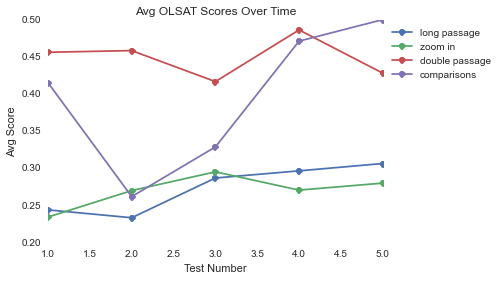

In [46]:
def getTrendsOverTime(df,testString,columns=['type','testNum']):
    if testString=='OL':
        sequencePos = -1
    elif testString=='PP_SAT':
        sequencePos = 3
    ol = df[df.testID.str.contains(testString)]
    ol['testNum']=ol.testID.str[sequencePos]
    trendsDF = groupData(ol,columns,'correct')
    trendsDF.rename(columns={'mean':'avgScore'},inplace=True)
    return trendsDF

def plotTrends(trendsDF,title):
    subjects = trendsDF.type.unique()
    for subject in subjects:
        foo = trendsDF[trendsDF['type']==subject]
        x = foo['testNum']
        y = foo['avgScore']
        plt.plot(x,y,'-o')
        plt.label=subject

    plt.ylabel('Avg Score')
    plt.xlabel('Test Number')
    plt.title(title)
    foo = ['long passage','zoom in','double passage','comparisons']
    plt.legend(foo,bbox_to_anchor=(1, 1), loc=2)

ol = getTrendsOverTime(df,'OL')
plotTrends(ol,'Avg OLSAT Scores Over Time')

In [5]:
ol.head()

NameError: name 'ol' is not defined

/Users/charlieg/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


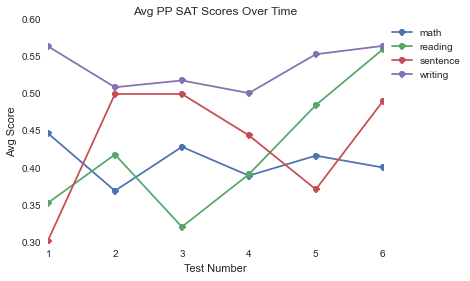

In [31]:
yl = getTrendsOverTime(df,'PP_SAT')
plotTrends(yl,'Avg PP SAT Scores Over Time')

In [32]:
topicTrends = getTrendsOverTime(df,'OL',columns=['type','topic','testNum'])
tt = topicTrends.groupby(by=['type','topic']).agg({'size':np.min,'avgScore':[np.min,np.max]})
tt = tt.reset_index()
tt['scoreChange'] = tt['avgScore']['amax'] - tt['avgScore']['amin']
topChanges = list(tt.sort('scoreChange',ascending=False)['topic'].head())

/Users/charlieg/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


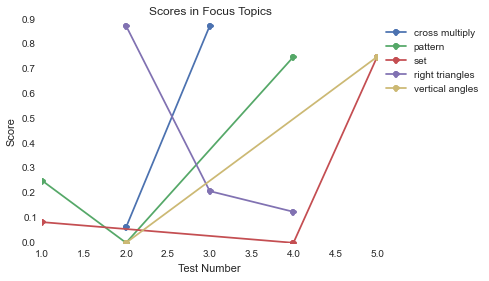

In [39]:
trendsDF = topicTrends
subjects = topChanges
title = 'Scores in Focus Topics'
for subject in subjects:
    foo = trendsDF[trendsDF['topic']==subject]
    x = foo['testNum']
    y = foo['avgScore']
    plt.plot(x,y,'-o')
    plt.label=subject

plt.ylabel('Score')
plt.xlabel('Test Number')
plt.title(title)
plt.legend(subjects,bbox_to_anchor=(1, 1), loc=2)

In [40]:
df

,firstName,lastName,testID,testQuestionNumber,testSectionNumber,type,CorrectAnswer,Studentsanswer,topic,correct,numTopics
0,Aeson,Purse,OLSAT8.PT2,1,2,math,A,B,backsolving,0,3
1,Aeson,Purse,OLSAT8.PT2,1,2,math,A,B,equations,0,3
2,Aeson,Purse,OLSAT8.PT2,1,2,math,A,B,substitution,0,3
3,Aeson,Purse,OLSAT7.PT1,1,2,sentence,E,C,DB,0,2
4,Aeson,Purse,OLSAT7.PT1,1,2,sentence,E,C,GC,0,2
5,Aeson,Purse,OLSAT4.PT4,1,2,math,A,A,translation,1,4
6,Aeson,Purse,OLSAT4.PT4,1,2,math,A,A,rate,1,4
7,Aeson,Purse,OLSAT4.PT4,1,2,math,A,A,equations,1,4
8,Aeson,Purse,OLSAT4.PT4,1,2,math,A,A,word problem,1,4
9,Aeson,Purse,OLSAT9.PT3,1,2,sentence,C,B,definition,0,2
